In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
%matplotlib inline

## Loading The Data

In [2]:
X = pd.read_csv('pump/train_x.csv')
y = pd.read_csv('pump/train_y.csv')
pump_data = pd.merge(X, y)
pump_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [3]:
pump_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

## Handling Missing values

In [4]:
explicit_missing = pump_data.isna().any()[pump_data.isna().any()].index
for col in explicit_missing:
    c = pump_data[col].isna().sum()
    print(f"Missing Values in {col}: {c}")

Missing Values in funder: 3635
Missing Values in installer: 3655
Missing Values in subvillage: 371
Missing Values in public_meeting: 3334
Missing Values in scheme_management: 3877
Missing Values in scheme_name: 28166
Missing Values in permit: 3056


In [5]:
def get_missing_columns(data, columns=[], missing_vals=[]):
    """
    Get Columns that contains implicit missing data on them
    """
    columns = list(data.select_dtypes('object').columns) + columns
    known_missing_vals = ['', 'none', 'None', '?']
    missing_vals = known_missing_vals + missing_vals
    
    columns_with_missing = []
    
    for val in missing_vals:
        for col in columns:
            if (data[col] == val).any():
                columns_with_missing.append(col)
                
    return set(columns_with_missing)

In [6]:
implicit_missing = get_missing_columns(pump_data)
print(f"Columns With Implicit Missing Values: {list(implicit_missing)}")

Columns With Implicit Missing Values: ['scheme_name', 'wpt_name', 'scheme_management', 'funder']


In [7]:
pump_data = pump_data.replace(['', 'none', 'None', '?'], np.nan)
get_missing_columns(pump_data)

set()

In [8]:
explicit_missing = pump_data.isna().any()[pump_data.isna().any()].index
for col in explicit_missing:
    c = pump_data[col].isna().sum()
    print(f"Missing Values in {col}: {c}")

Missing Values in funder: 3637
Missing Values in installer: 3655
Missing Values in wpt_name: 3565
Missing Values in subvillage: 371
Missing Values in public_meeting: 3334
Missing Values in scheme_management: 3878
Missing Values in scheme_name: 28835
Missing Values in permit: 3056


### Handling Zero's Values in ```construction_year``` column

In [9]:
num_zeros = (pump_data['construction_year'] == 0).sum()
print(f"Number of zeros in construction_year: {num_zeros}")

Number of zeros in construction_year: 20709


In [10]:
pump_data.groupby(pump_data['construction_year']==0)['status_group'].value_counts()

construction_year  status_group           
False              functional                 21704
                   non functional             14459
                   functional needs repair     2528
True               functional                 10555
                   non functional              8365
                   functional needs repair     1789
Name: status_group, dtype: int64

In [11]:
mean_construction_year = pump_data['construction_year'].mean()
pump_data['construction_year'].replace(0, mean_construction_year, inplace=True)

In [12]:
num_zeros = (pump_data['construction_year'] == 0).sum()
print(f"Number of zeros in construction_year: {num_zeros}")

Number of zeros in construction_year: 0


### Handling Missing Values in ```scheme_name``` column

In [13]:
pump_data[pump_data.scheme_name.isna()]['status_group'].value_counts()

functional                 14914
non functional             11887
functional needs repair     2034
Name: status_group, dtype: int64

In [14]:
def replace_scheme_name(df, top=200):
    great_than_top = df['scheme_name'].value_counts() >= top
    top_schemes_counts = df['scheme_name'].value_counts()[great_than_top]
    top_schemes_names = top_schemes_counts.index
    probs = top_schemes_counts.apply(lambda x: x/top_schemes_counts.sum())
    get_random_scheme = lambda: np.random.choice(top_schemes_names, p=probs)

    num_nans = df['scheme_name'].isna().sum()
    values = [get_random_scheme() for i in range(num_nans)]

    df.loc[df['scheme_name'].isna(), 'scheme_name'] = values

In [15]:
replace_scheme_name(pump_data)

In [16]:
explicit_missing = pump_data.isna().any()[pump_data.isna().any()].index
for col in explicit_missing:
    c = pump_data[col].isna().sum()
    print(f"Missing Values in {col}: {c}")

Missing Values in funder: 3637
Missing Values in installer: 3655
Missing Values in wpt_name: 3565
Missing Values in subvillage: 371
Missing Values in public_meeting: 3334
Missing Values in scheme_management: 3878
Missing Values in permit: 3056


## Exploratory Data Analysis

In [17]:
categorical_columns = pump_data.select_dtypes('object').columns
numerical_columns = pump_data.select_dtypes('number').columns
print(f"Numerical Columns: {len(numerical_columns)}")
print(f"Non Numerical Columns: {len(categorical_columns)}")

Numerical Columns: 10
Non Numerical Columns: 31


In [18]:
pump_data[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
id,59400.0,37115.131768,21453.128371,0.000000,18519.750000,37061.500000,55656.500000,7.424700e+04
amount_tsh,59400.0,317.650385,2997.574558,0.000000,0.000000,0.000000,20.000000,3.500000e+05
gps_height,59400.0,668.297239,693.116350,-90.000000,0.000000,369.000000,1319.250000,2.770000e+03
longitude,59400.0,34.077427,6.567432,0.000000,33.090347,34.908743,37.178387,4.034519e+01
latitude,59400.0,-5.706033,2.946019,-11.649440,-8.540621,-5.021597,-3.326156,-2.000000e-08
num_private,59400.0,0.474141,12.236230,0.000000,0.000000,0.000000,0.000000,1.776000e+03
region_code,59400.0,15.297003,17.587406,1.000000,5.000000,12.000000,17.000000,9.900000e+01
district_code,59400.0,5.629747,9.633649,0.000000,2.000000,3.000000,5.000000,8.000000e+01
population,59400.0,179.909983,471.482176,0.000000,0.000000,25.000000,215.000000,3.050000e+04
construction_year,59400.0,1754.107224,331.903637,1300.652475,1300.652475,1986.000000,2004.000000,2.013000e+03


In [19]:
pump_data.groupby('num_private')['status_group'].value_counts()

num_private  status_group           
0            functional                 31798
             non functional             22576
             functional needs repair     4269
1            functional                    40
             non functional                27
                                        ...  
672          functional                     1
698          functional                     1
755          functional                     1
1402         functional                     1
1776         non functional                 1
Name: status_group, Length: 113, dtype: int64

In [20]:
pump_data[categorical_columns].describe().T

,count,unique,top,freq
date_recorded,59400,356,2011-03-15,572
funder,55763,1896,Government Of Tanzania,9084
installer,55745,2145,DWE,17402
wpt_name,55835,37398,Shuleni,1748
basin,59400,9,Lake Victoria,10248
subvillage,59029,19287,Madukani,508
region,59400,21,Iringa,5294
lga,59400,125,Njombe,2503
ward,59400,2092,Igosi,307
public_meeting,56066,2,True,51011


<AxesSubplot:xlabel='num_private', ylabel='status_group'>

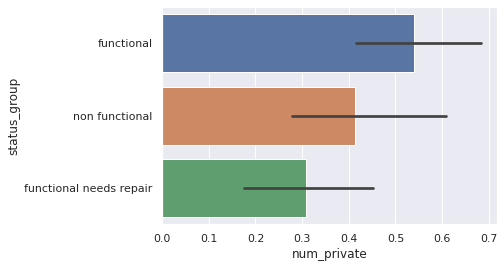

In [21]:
seaborn.barplot(data=pump_data, x='num_private', y='status_group')


## Building The Model


### Logistic Regression (Numerical Features)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [23]:
X_numerics = pump_data[['amount_tsh', 'gps_height', 'longitude', 'latitude',
               'num_private', 'population', 'construction_year']]
y = LabelEncoder().fit_transform(pump_data['status_group'])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_numerics, y, test_size=0.30, random_state=42)

In [25]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
train_score = logreg.score(X_train, y_train)
test_score = logreg.score(X_test, y_test)

print(f"Training Score: {train_score}")
print(f"Testing Score: {test_score}")

Training Score: 0.5375661375661376
Testing Score: 0.5364197530864198


In [26]:
pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler()),
    ('logreg', LogisticRegression(max_iter=1000)),
])

pipe.fit(X_train, y_train)
train_score = pipe.score(X_train, y_train)
test_score = pipe.score(X_test, y_test)
print(f"Training Score: {train_score}")
print(f"Testing Score: {test_score}")

Training Score: 0.5367243867243867
Testing Score: 0.5436026936026936


### Logistic Regression

In [27]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA, TruncatedSVD

In [29]:
y = LabelEncoder().fit_transform(pump_data['status_group'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [30]:
numericals_features = ['amount_tsh', 'gps_height', 'longitude', 'latitude',
                       'num_private', 'population', 'construction_year']

categorical_features = ['basin', 'public_meeting', 'scheme_management', 'permit',
                        'extraction_type_class', 'payment_type', 'water_quality',
                        'quantity', 'source', 'waterpoint_type']

get_numerical = FunctionTransformer(lambda x: x[numericals_features])
get_categorical = FunctionTransformer(lambda x: x[categorical_features])

numerical_pipeline = Pipeline([
                        ('selector', get_numerical),
                        ('imputer', SimpleImputer()),
                        ('scaler', StandardScaler())])
categorical_pipeline = Pipeline([
                        ('selector', get_categorical),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('encoder', OneHotEncoder()),
                        ])
pipeline = Pipeline([
                ('union', FeatureUnion([
                    ('numerical', numerical_pipeline),
                    ('categorical', categorical_pipeline),
                ])),
                ('logreg', LogisticRegression(max_iter=1000))])

pipeline.fit(X_train, y_train);
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Training Score: {train_score}")
print(f"Testing Score: {test_score}")

Training Score: 0.7234728234728235
Testing Score: 0.7215488215488215


## Random Forest

In [43]:
rf_pipeline = Pipeline([
                ('union', FeatureUnion([
                    ('numerical', numerical_pipeline),
                    ('categorical', categorical_pipeline)
                ])),
                ('clf', RandomForestClassifier(
                            max_depth=50, max_features=10, min_samples_split=10))
                ])

rf_pipeline.fit(X_train, y_train);
train_score = rf_pipeline.score(X_train, y_train)
test_score = rf_pipeline.score(X_test, y_test)

print(f"Training Score: {train_score}")
print(f"Testing Score: {test_score}")

Training Score: 0.9008417508417509
Testing Score: 0.8003928170594837
